# 查看根目录下需要运行的文件夹

In [10]:
from pathlib import Path

version = "v1"
run_type = "pose_and_det"  # "pose_and_det" or "cls"

path = Path("/workspace/models/SAHI/run_v8")
chosen_dirs = [d / "raw_data" for d in path.iterdir() if d.is_dir()]
print("子文件夹路径列表：", chosen_dirs)

子文件夹路径列表： [PosixPath('/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data')]


# 简单统计 -- 统计各类别objects数量，并导出为CSV文件
### 输入输出
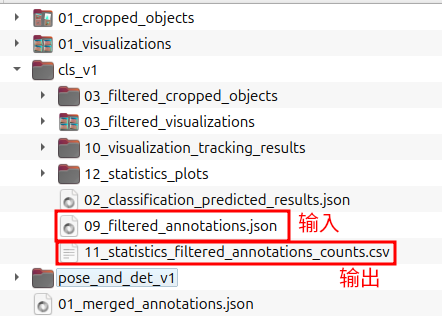

### 效果
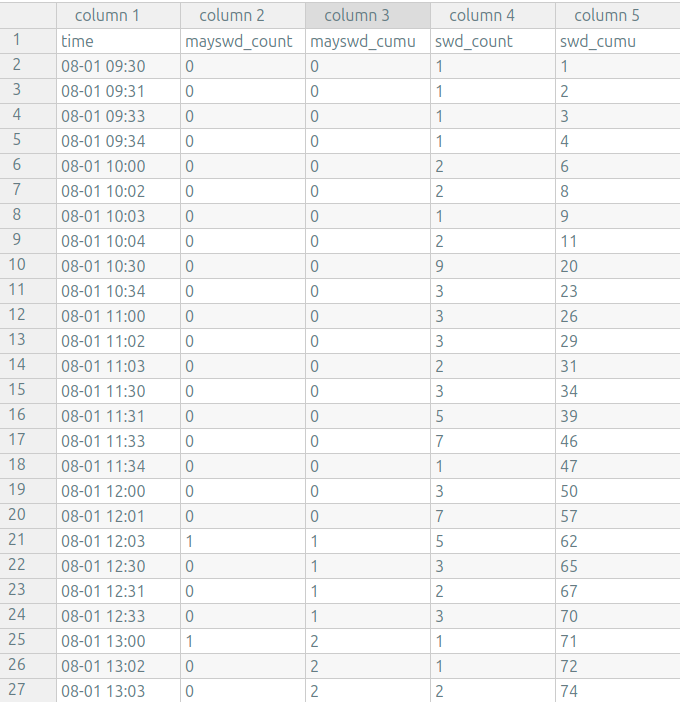

In [ ]:
# 统计每个类别在每个时间点的数量并导出为 CSV

"""
统计: 各类别(label)在每个时刻(original_name解析)的数量 & 按时间排序后的累积数量
输入: 03_filtered_annotations.json
输出: 04_filtered_annotations_counts.csv  |  04_filtered_annotations_cumulative.csv
"""

import json, csv, re
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Iterable, Optional

# ───────────────────────────────────────────────────────────────────────────────
# 1) original_name → 解析时间键
#    假设命名类似: "0801_1203_840" → MMDD=0801, HHMM=1203
#    若解析失败: 回退到原字符串并按自然排序
# ───────────────────────────────────────────────────────────────────────────────

_TIME_RE = re.compile(r"^(\d{4})_(\d{4})(?:_.+)?$")  # e.g. 0801_1203_...

def parse_time_key(name: str) -> Tuple[int,int,int,int,str]:
    """
    返回一个可排序的键 (MM, DD, HH, mm, display_str)
    解析失败时, 返回 (9999, 9999, 99, 99, name) 确保排在最后并用原名展示
    """
    m = _TIME_RE.match(name)
    if not m:
        # 回退: 把名字放最后，display 就用原名
        return (9999, 9999, 99, 99, name)
    mmdd, hhmm = m.group(1), m.group(2)
    try:
        MM  = int(mmdd[:2])
        DD  = int(mmdd[2:])
        HH  = int(hhmm[:2])
        mm  = int(hhmm[2:])
        disp = f"{MM:02d}-{DD:02d} {HH:02d}:{mm:02d}"
        return (MM, DD, HH, mm, disp)
    except Exception:
        return (9999, 9999, 99, 99, name)

# ───────────────────────────────────────────────────────────────────────────────
# 2) 读取与计数
#    JSON 结构: { original_name: [ { label: "...", ... }, ... ], ... }
# ───────────────────────────────────────────────────────────────────────────────

def load_annotations(fp: Path) -> Dict[str, List[dict]]:
    with fp.open("r", encoding="utf-8") as f:
        return json.load(f)

def compute_counts_by_time(data: Dict[str, List[dict]]) -> Tuple[List[str], List[Tuple[str, Dict[str,int]]]]:
    """
    返回:
      - 所有出现过的 label 列表(按字母序)
      - 按时间排序的 [(display_time, {label: count, ...}), ...]
    """
    # 收集 label 集
    all_labels = set()
    # 临时记录: time_key → Counter(label)
    time_counters: Dict[Tuple[int,int,int,int,str], Counter] = {}  # tuple: (MM, DD, HH, mm, display_str)

    # 遍历数据, 统计每个时间点的类别数量
    for original_name, ann_list in data.items():
        key = parse_time_key(original_name)
        ctr = time_counters.setdefault(key, Counter())
        for ann in ann_list:
            lbl = ann.get("label")
            if not lbl:
                continue
            all_labels.add(lbl)
            ctr[lbl] += 1
    # 按字母序排序所有 label
    labels_sorted = sorted(all_labels)
    # 按解析后的时间键排序
    entries: List[Tuple[str, Dict[str,int]]] = []
    for k in sorted(time_counters.keys()):
        disp = k[4]                         # display time 部分 -- display_str
        ctr  = time_counters[k] # Counter
        # print(f"[debug] {disp} 计数: {ctr}")
        row_counts = {lbl: ctr.get(lbl, 0) for lbl in labels_sorted} # 保持列顺序
        entries.append((disp, row_counts)) # (display, {label: count, ...})
    return labels_sorted, entries

# ───────────────────────────────────────────────────────────────────────────────
# 3) 写出 CSV: 原始计数 & 累积计数
# ───────────────────────────────────────────────────────────────────────────────

def write_counts_and_cumu_onefile(
    labels: List[str],
    entries: List[Tuple[str, Dict[str, int]]],
    out_path: Path,
) -> None:
    """
    输出一个 CSV，每个类别有两列：<label>_count, <label>_cumu
    """
    # 累积计数器
    cumu = {lbl: 0 for lbl in labels}

    # 构造表头
    headers = ["time"]
    for lbl in labels:
        headers.append(f"{lbl}_count")
        headers.append(f"{lbl}_cumu")

    with out_path.open("w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(headers)

        for disp, row_counts in entries:
            row = [disp]
            for lbl in labels:
                count = row_counts.get(lbl, 0)
                cumu[lbl] += count
                row.extend([count, cumu[lbl]])
            writer.writerow(row)



# ───────────────────────────────────────────────────────────────────────────────
# 4) 主流程
# ───────────────────────────────────────────────────────────────────────────────

def run_analysis(
    in_path: Path,
    out_path: Path,
):
    if not in_path.exists():
        raise FileNotFoundError(f"未找到输入文件: {in_path.resolve()}")

    data = load_annotations(in_path)
    labels, entries = compute_counts_by_time(data)

    # 输出一个 CSV
    write_counts_and_cumu_onefile(labels, entries, out_path)

    # 友好打印预览
    print(f"✅ 统计完成，共发现 {len(labels)} 个类别: {labels}")
    print(f"✅ 时间点数量: {len(entries)}")
    print(f"💾 已写出: {out_path}")



In [8]:
for chosen_dir in chosen_dirs:
    print(f"选择的目录: {chosen_dir}")
    run_analysis(
        in_path = chosen_dir.parent / "raw_data_sliced_merge" / f"{run_type}_{version}" / "09_filtered_annotations.json",
        out_path = chosen_dir.parent / "raw_data_sliced_merge" / f"{run_type}_{version}" / "11_statistics_filtered_annotations_counts.csv",
    )

选择的目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge
✅ 统计完成，共发现 2 个类别: ['mayswd', 'swd']
✅ 时间点数量: 71
💾 已写出: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/cls_v1/11_statistics_filtered_annotations_counts.csv


# 去重统计 -- 统计各类别除去多张照片之间重复位置的objects数量，并导出为CSV文件